# ARIMA Model Prototype

In [3]:
from omsapi import OMSAPI
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep

In [4]:
#The version of statsmodels is 0.10.2
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA

In [5]:
omsapi = OMSAPI(api_url="https://vocms0185.cern.ch/agg/api", api_version="v1", cert_verify=False)
omsapi.auth_oidc("oms-api-client", "4577f6da-bbf7-4f5e-a898-f8db325e7e5e", audience="cmsoms-int-0185")

In [6]:
q=omsapi.query('datasetrates').paginate(page=1,per_page=1000).filter("run_number",315721).filter('dataset_name','SingleMuon')

In [7]:
response=q.data()
folded_json=response.json()

https://vocms0185.cern.ch/agg/api/v1/datasetrates/?filter[run_number][EQ]=315721&filter[dataset_name][EQ]=SingleMuon&page[offset]=0&page[limit]=1000


In [8]:
df=pd.json_normalize(folded_json['data'])
df.set_index('attributes.first_lumisection_number',inplace=True)
df=df[23:628]

In [9]:
plt.style.use([hep.style.ROOT,hep.style.firamath])

### Degree of difference 

In [10]:
df_change=df['attributes.rate'].diff()
rate_change=df_change.dropna()
rate_change

attributes.first_lumisection_number
34     173.999517
35      52.508730
36    -223.205001
37     -46.674427
38     127.196392
          ...    
634      0.000000
635      0.042899
636     -0.042899
637      0.042899
638      0.000000
Name: attributes.rate, Length: 604, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 1, 'Rate(t) - Rate(t-1)')

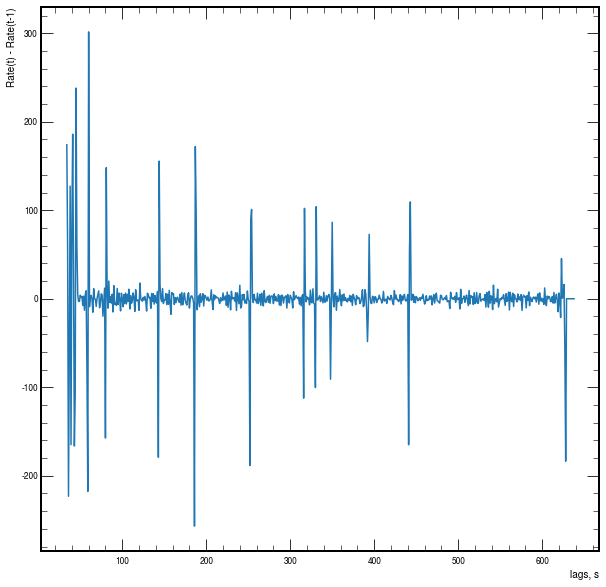

In [11]:
ax,f=plt.subplots(figsize=(10,10))
plt.plot(rate_change)
plt.legend()
plt.xlabel("lags, s")
plt.ylabel("Rate(t) - Rate(t-1)")

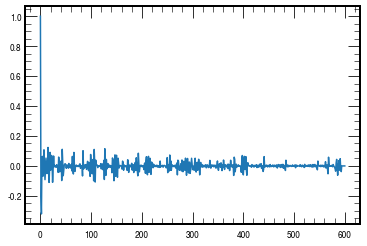

In [12]:
plt.plot(acf(rate_change,nlags=600))

### Autocorrelation and Partial autocorrelation plot

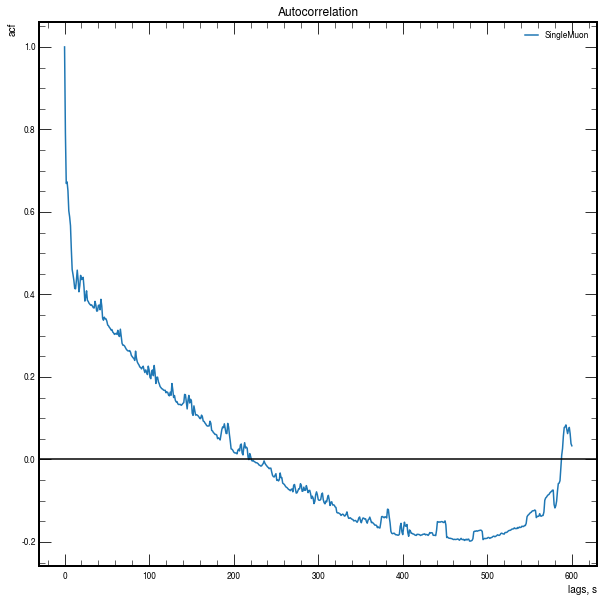

In [13]:
f,ax=plt.subplots(figsize=(10,10))
plt.plot(acf(df['attributes.rate'],nlags=600),label=df['attributes.dataset_name'][33])
plt.legend()
plt.title("Autocorrelation")
plt.xlabel("lags, s")
plt.ylabel("acf")
plt.axhline(color='black')

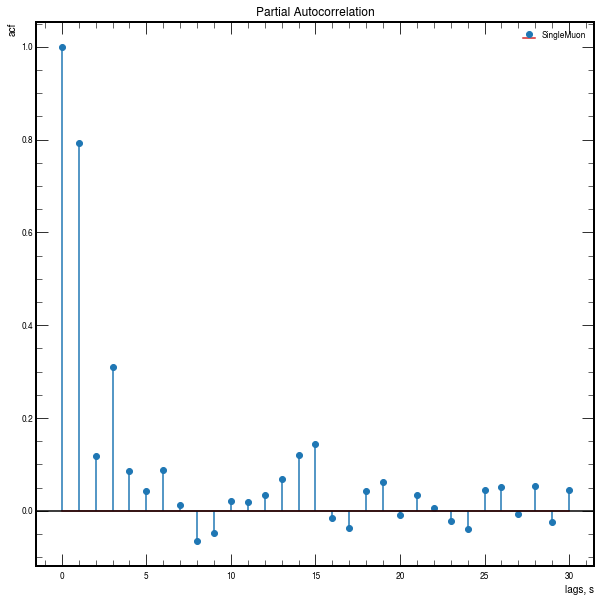

In [14]:
f,ax=plt.subplots(figsize=(10,10))
plt.stem(pacf(df['attributes.rate'],nlags=30),label=df['attributes.dataset_name'][33])
plt.legend()
plt.title("Partial Autocorrelation")
plt.xlabel("lags, s")
plt.ylabel("acf")
plt.axhline(color='black')

### Model Creation 

In [15]:
model=ARIMA(df['attributes.rate'],order=(2,1,0))
model_fit=model.fit()

C:\Users\Kasidit\Desktop\TkDPG-Summer-Student-Time-Series-Analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kasidit\Desktop\TkDPG-Summer-Student-Time-Series-Analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kasidit\Desktop\TkDPG-Summer-Student-Time-Series-Analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [16]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        attributes.rate   No. Observations:                  605
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2981.269
Date:                Mon, 11 Jul 2022   AIC                           5968.538
Time:                        11:50:39   BIC                           5981.749
Sample:                             0   HQIC                          5973.679
                                - 605                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2969      0.013    -22.239      0.000      -0.323      -0.271
ar.L2         -0.3979      0.015    -26.568      0.000      -0.427      -0.369
sigma2      1133.6446     19.264     58.849      0.000    1095.889    1171.401
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):             11754.67
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -1.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
df['attributes.rate']

attributes.first_lumisection_number
33     120.632801
34     294.632318
35     347.141048
36     123.936046
37      77.261620
          ...    
634      0.000000
635      0.042899
636      0.000000
637      0.042899
638      0.042899
Name: attributes.rate, Length: 605, dtype: float64

In [18]:
model_diff=df['attributes.rate'].diff()

Text(0.5, 1.0, 'SingleMuon')

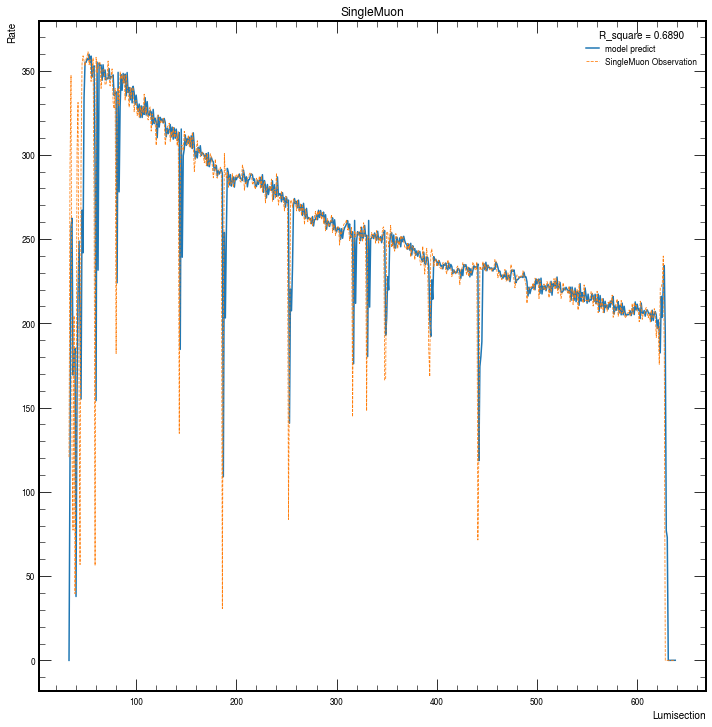

In [19]:
plt.subplots(figsize=(10,10))
model_predict=model_fit.predict(start=0,end=604)
corr_matrix=np.corrcoef(df['attributes.rate'],model_predict)
corr=corr_matrix[0,1]
R_sq=corr**2
plt.plot(model_predict,label='model predict')
plt.plot(df['attributes.rate'],ls='--',lw=0.8,label='SingleMuon Observation')
plt.legend(title='R_square = {:.4f}'.format(R_sq))
plt.xlabel("Lumisection")
plt.ylabel("Rate")
plt.tight_layout()
plt.title("SingleMuon")


Text(1, 0, 'Lumisection')

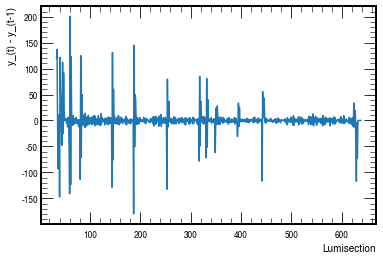

In [20]:
model_predict.diff().plot()
plt.ylabel('y_(t) - y_(t-1)')
plt.xlabel('Lumisection')

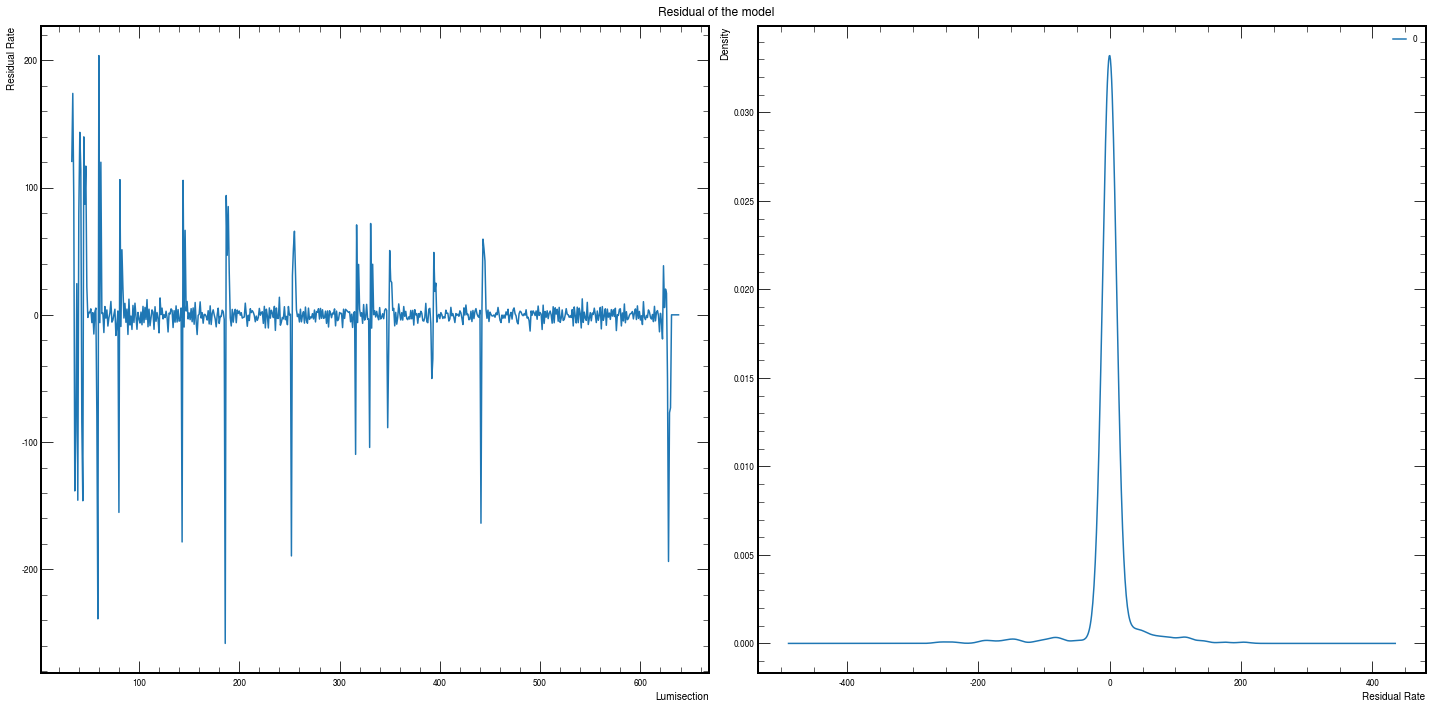

In [21]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
residual = pd.DataFrame(model_fit.resid)
ax1.plot(residual)
ax1.set_xlabel("Lumisection")
ax1.set_ylabel("Residual Rate")
residual.plot(ax=ax2,kind='kde')
ax2.set_xlabel("Residual Rate")
plt.suptitle("Residual of the model")
plt.tight_layout()

In [22]:
residual

,0
attributes.first_lumisection_number,
33,1.206328e+02
34,1.740356e+02
35,8.954230e+01
36,-1.383789e+02
37,-9.203892e+01
...,...
634,1.773882e-32
635,4.289929e-02
636,-3.016451e-02


In [23]:
print("Residual description \n", residual.describe())

Residual description 
                 0
count  605.000000
mean    -0.162545
std     34.200750
min   -258.247440
25%     -3.839694
50%      0.050943
75%      3.767366
max    203.754847


In [24]:
model_fit.param_names

['ar.L1', 'ar.L2', 'sigma2']

In [25]:
model_fit.params

ar.L1       -0.296853
ar.L2       -0.397925
sigma2    1133.644616
dtype: float64

In [26]:
model_fit.arparams

array([-0.29685282, -0.39792498])

For prediction the data from coefficient, we calculate according to the equation for ARIMA(p,d,q): 
(At the start point, we'll have d previous data for differencing : ```y[0] , y[1], ..., y[d-1]```

And we got the p + q coefficients, ```arcoef = [arcoef[0],arcoef[1],...,arcoef[p-1]]``` and ```macoef[0],macoef[1],...,macoef[q-1]```

In order to predict the value of data, we use the formula for d = 1 (We won't generalize the d, which can easily do through loops): 
                                                ```y[t] = y[t-1] + {arcoef[0] * y[t-1] + ... + arcoef[p+1] * y[t-p]} + {arcoef[0] * e[t-1] + ... + arcoef[q-1] * e[t-q] }```
                            

In [27]:
df_diff=df['attributes.rate'].diff()
predictor=df_diff.dropna().reset_index(drop=True)
predictor

0      173.999517
1       52.508730
2     -223.205001
3      -46.674427
4      127.196392
          ...    
599      0.000000
600      0.042899
601     -0.042899
602      0.042899
603      0.000000
Name: attributes.rate, Length: 604, dtype: float64

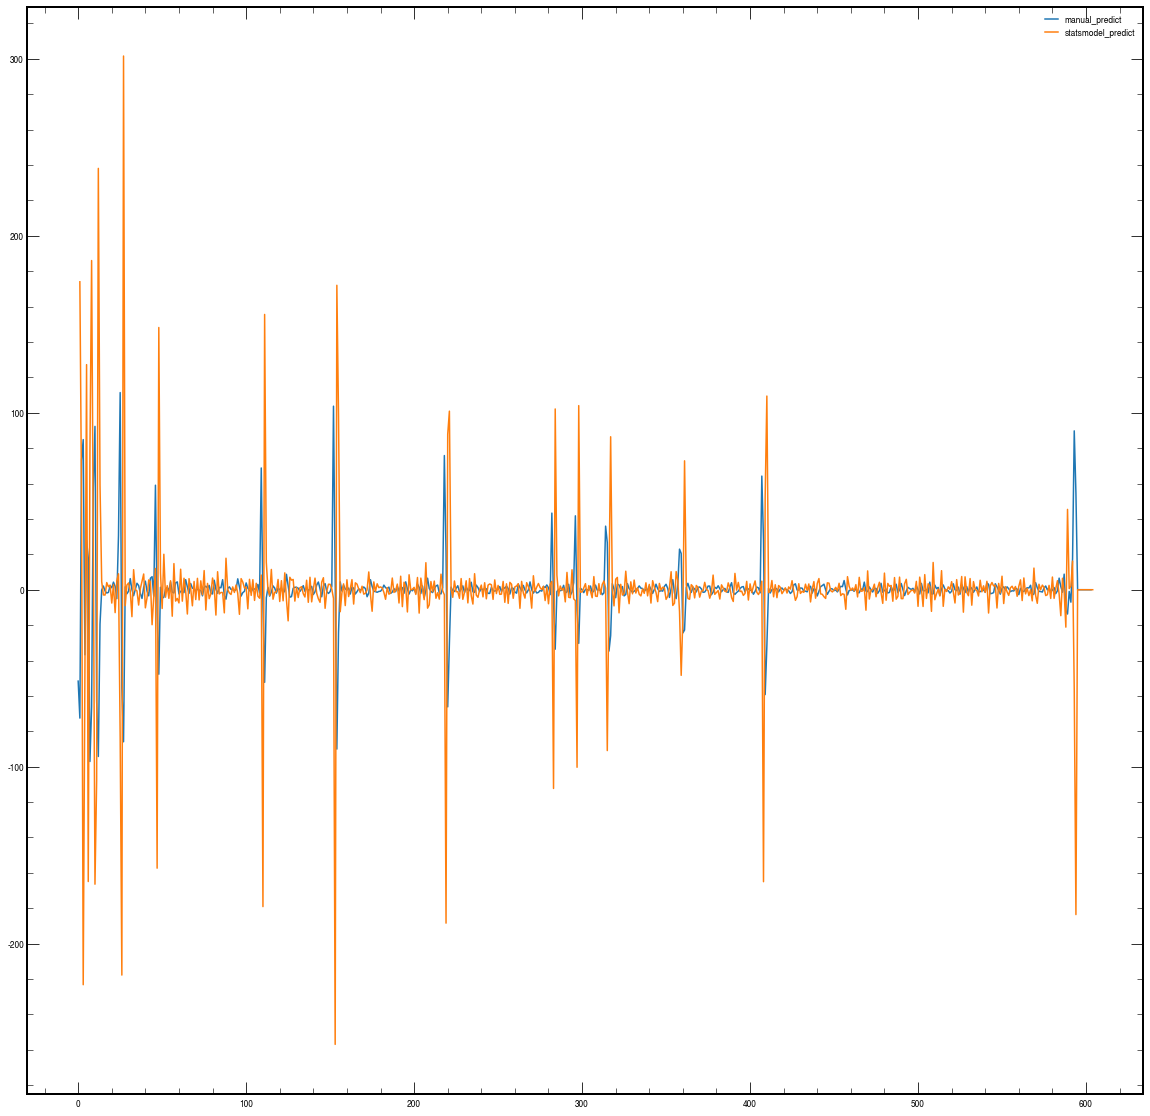

In [28]:
predict_diff = []
for i in range(len(predictor)):
    if i == 0 :
        predict_diff.append(predictor[i]*model_fit.arparams[0])
    else :
        predict_diff.append(predictor[i-1]*model_fit.arparams[0] + predictor[i]*model_fit.arparams[1])
df_predict = pd.DataFrame(predict_diff)
fig,ax = plt.subplots(figsize=(20,20))
plt.plot(predict_diff,label='manual_predict')
plt.plot(model_diff.reset_index(drop=True),label='statsmodel_predict')
plt.legend()


## ARIMA model for path data 

In [29]:
path_q = omsapi.query("hltpathrates").paginate(page=1, per_page=700).filter("run_number",315721).filter('path_name','HLT_IsoMu24_v11')
path_response=path_q.data()
path_folded_json=path_response.json()
path_df=pd.json_normalize(path_folded_json['data'])
path_df.set_index('attributes.first_lumisection_number',inplace=True)
path_df=path_df[23:628]

https://vocms0185.cern.ch/agg/api/v1/hltpathrates/?filter[run_number][EQ]=315721&filter[path_name][EQ]=HLT_IsoMu24_v11&page[offset]=0&page[limit]=700


In [30]:
path_df

,id,type,attributes.fill_number,attributes.start_time,attributes.last_lumisection_number,attributes.rate,attributes.run_number,attributes.last_lumisection_in_run,attributes.counter,attributes.path_name,links.self
attributes.first_lumisection_number,,,,,,,,,,,
33,315721__HLT_IsoMu24_v11__33,hltpathrates,6642,2018-05-05T05:08:13Z,33,103.172790,315721,640,2405,HLT_IsoMu24_v11,https://https://vocms0185.cern.ch/agg/api/v1/h...
34,315721__HLT_IsoMu24_v11__34,hltpathrates,6642,2018-05-05T05:08:37Z,34,246.928308,315721,640,5756,HLT_IsoMu24_v11,https://https://vocms0185.cern.ch/agg/api/v1/h...
35,315721__HLT_IsoMu24_v11__35,hltpathrates,6642,2018-05-05T05:09:00Z,35,292.959245,315721,640,6829,HLT_IsoMu24_v11,https://https://vocms0185.cern.ch/agg/api/v1/h...
36,315721__HLT_IsoMu24_v11__36,hltpathrates,6642,2018-05-05T05:09:23Z,36,105.146158,315721,640,2451,HLT_IsoMu24_v11,https://https://vocms0185.cern.ch/agg/api/v1/h...
37,315721__HLT_IsoMu24_v11__37,hltpathrates,6642,2018-05-05T05:09:47Z,37,66.450999,315721,640,1549,HLT_IsoMu24_v11,https://https://vocms0185.cern.ch/agg/api/v1/h...
...,...,...,...,...,...,...,...,...,...,...,...
634,315721__HLT_IsoMu24_v11__634,hltpathrates,6642,2018-05-05T09:01:43Z,634,0.000000,315721,640,0,HLT_IsoMu24_v11,https://https://vocms0185.cern.ch/agg/api/v1/h...
635,315721__HLT_IsoMu24_v11__635,hltpathrates,6642,2018-05-05T09:02:06Z,635,0.000000,315721,640,0,HLT_IsoMu24_v11,https://https://vocms0185.cern.ch/agg/api/v1/h...
636,315721__HLT_IsoMu24_v11__636,hltpathrates,6642,2018-05-05T09:02:30Z,636,0.000000,315721,640,0,HLT_IsoMu24_v11,https://https://vocms0185.cern.ch/agg/api/v1/h...


In [31]:
#fitting path's ARIMA by imposing the constrained params from singlemuon model
path_model=ARIMA(path_df['attributes.rate'],order=(2,1,0))
path_model_constrained_fit=path_model.fit_constrained({'ar.L1':model_fit.arparams[0],'ar.L2':model_fit.arparams[1]})
path_model_constrained_fit.summary()

C:\Users\Kasidit\Desktop\TkDPG-Summer-Student-Time-Series-Analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kasidit\Desktop\TkDPG-Summer-Student-Time-Series-Analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kasidit\Desktop\TkDPG-Summer-Student-Time-Series-Analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        attributes.rate   No. Observations:                  605
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2880.255
Date:                Mon, 11 Jul 2022   AIC                           5762.510
Time:                        11:50:41   BIC                           5766.914
Sample:                             0   HQIC                          5764.224
                                - 605                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1 (fixed)    -0.2969        nan        nan        nan         nan         nan
ar.L2 (fixed)    -0.3979        nan        nan        nan         nan         nan
sigma2          811.3220     13.674     59.333      0.000     784.521     838.123
===================================================================================
Ljung-Box (L1) (Q):                   1.86   Jarque-Bera (JB):             11685.73
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -1.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'HLT_IsoMu24_v11')

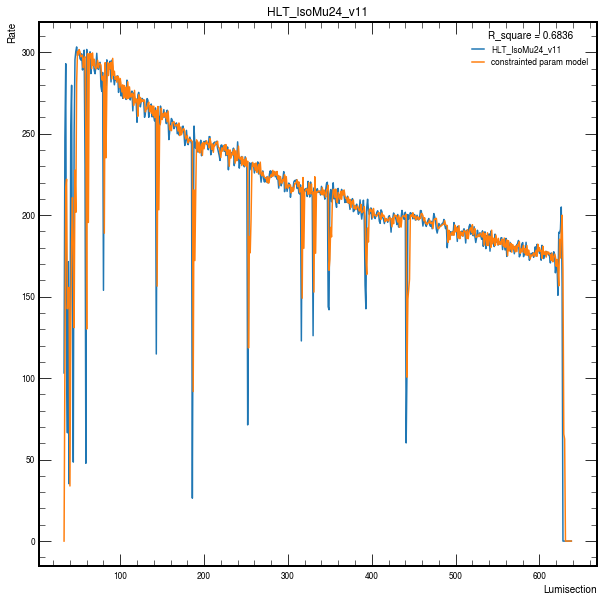

In [32]:
path_model_constrained_predict=path_model_constrained_fit.predict(start=0,end=604)
corr_matrix=np.corrcoef(path_df['attributes.rate'],path_model_constrained_predict)
corr=corr_matrix[0,1]
R_sq=corr**2
plt.subplots(figsize=(10,10))
#plt.plot(path_model_predict,label='ARIMA to path')
plt.plot(path_df['attributes.rate'],label=path_df['attributes.path_name'][100])
plt.plot(path_model_constrained_predict,label='constrainted param model')
plt.legend(title='R_square = {:.4f}'.format(R_sq))
plt.xlabel("Lumisection")
plt.ylabel("Rate")
plt.title(path_df["attributes.path_name"][100])

In [33]:
#fitting the ARIMA from the path data
path_model=ARIMA(path_df['attributes.rate'],order=(2,1,0))
path_model_fit=path_model.fit()
path_model_fit.summary()
path_model_fit.predict(start=1,ends=600)

C:\Users\Kasidit\Desktop\TkDPG-Summer-Student-Time-Series-Analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kasidit\Desktop\TkDPG-Summer-Student-Time-Series-Analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kasidit\Desktop\TkDPG-Summer-Student-Time-Series-Analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


attributes.first_lumisection_number
34     1.031503e+02
35     2.156563e+02
36     2.228798e+02
37     1.438888e+02
38     1.515311e+02
           ...     
634    3.401193e-31
635   -8.118079e-32
636    9.437725e-32
637   -3.746039e-48
638    2.994127e-02
Name: predicted_mean, Length: 604, dtype: float64